# Single frequency component modelling of speech

This notebook will examine the plausibility of modelling the real and imaginary part of warped frequency coefficients using an auto-regressive model.

This notebook comprises the following steps:
1. Load data
2. Pass data through warped filter bank and calculate warped frequency coefficients
3. Model the warped frequency coefficients using an auto-regressive model
4. Infer auto-regressive parameters
5. Evaluate performance on coefficient prediction

## Load packages and functions

In [1]:
using ForneyLab       # based on last official release
using LinearAlgebra
using Plots
using PyPlot
using ProgressMeter
using Compat
using WAV
using Base64
using FileIO
using HDF5
using FLAC
using DSP
using LAR
using LAR.AR
using LAR.DataAR
using FFTW

include("../functions/auxiliary/buffer.jl")
include("../functions/auxiliary/audioplayer.jl")
include("../functions/auxiliary/workflow.jl")
include("../functions/auxiliary/fourier.jl")
include("../functions/auxiliary/warpedfilter.jl")
;

## Adjustable parameters

In [2]:
# signal preprocessing
sound_file = "../data/obama.wav"      # specify sound location
fs_desired = 8000                 # specify desired sampling frequency

# signal warping
nr_taps_warped = 32                # number of taps of warped filter bank
z_pole = 0.4092                    # pole location of all-pass filter segments (0.5756 ~ approximation Bark scale)
window = rectangularwindow         # specify windowing function from fourier.jl file

# inference and modelling
bin = 8                            # specify which bin to model (should be between 1 and half `nr_taps_warped`)
bin_c = "real"                     # specify whether to model the `real` or `imaginary` part
AR_order = 20                       # order of auto-regressive model
iterations = 3                     # number of iterations for variational message passing
Λ_meas = 1e10                      # assumed precision of measurement noise
;

## Load data

In [3]:
# load and process speech signal
x_time, fs_time = wavread(sound_file, format="native")
fs_time = Int(fs_time)
x_time = x_time[20*fs_time+1:23*fs_time]
x_time = resample(x_time, fs_desired/fs_time)
x_time = 100*x_time/var(x_time)

# specify time axis
t = collect((1:length(x_time))/fs_desired)

# create audioplayer
audioplayers(x_time, fs=fs_desired)
;

<source src="data:audio/wav;base64,UklGRjx3AQBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQB3AQCnCOW8wa2AvsC2BL3R5W49mfDVvQbAob3dP4e+AVH2vZZYaTxgBAu9CZfmPO4m7r2QBDm9BUgRPnOnYD39fSg9Hupave+yprw3dLc9gd8iO8F+a72y35i8LSgMPVvOYj7uO+090rUIvgCzSz2afRQ++WxGPrrIGj1J1Eu+9WEVuUv/8byzSAW+6pLavQzAgr6Zld69M4guvLO5YDyyPbc9vyLQvVZskb22nLU9To6SPSU4nD2pd/K80HVUvQV9PT1KJw+77lO2vJXQHjwySjw91LlDPuzn5D3ewZC96/jQPRb28z2IKRg+sQo9PPjLMb69Iqk8MbJ2vVxQBr7YjHW9ky89vosUib3ef5e8TDHqvMTAhT1I0gm+bZyNvTqlpD29lLo993ANPugwkzpQky+9kbk0PONVQb0dyg29CQAFPdA5xD19Zlc+bTqgPVKLlr2cW8M9Wh3BPSHxAT5yHeS8CHMivlG+zTyig6a9a5H9vfVFsr0tPia+cjssvb6YaL3OlBe9liEWPNLv672fF128mGPTPUGU3T1Pc+A9K704vQ9nZb2cfFC80s6hvBocqDo6DLA9ySEFPhfoLD7xhFw9Wuyxva3Gzj1YuPE99XX3PS/h5rx21SO+T8b2PPrmu71tB769oLSZvSXvK75Jv0+9fDezvXHwQr2aM/E7gOvYvXEy1TmvRMM9oG2LPdwMMz1+/KO9QbElvahdhzxjlqY8kOdePaSQWT2hZQM+GUwQPsSClD05cLC83a3EPZ02DD6d9pQ9Zy0cvbg/Ib70j4y8AUR3vX6WjL1+GRG9SOIIvleTo7047b+9Ey4ivWqKA7uXB+K9Kv/QvNqORz2Mmn09r/fTPDzrg70iAXe8o66WPKc8CD09HZk9ZDL7PFWvyD0nj/I902iUPeOIDT0evGQ9gRaiPaJ4Az0QwRa9bPlmvQZhKrsMUFs8kNaNvPl0Kr0M43S96uCzvYe2xL0p36C6ruyxPMZzhL1d1FW90X4mvW3NFbvGaia8p1ZKvZwLebs8Dp27xPmtPGY2Hj0SPQe8jJ5gPGDY9zy2rAY985yhPK5DTrwq6Aw9ROxhPURgFT1Ca089jAY3PfMC3Tz6ep08LQA6vCbX0jrCh7a6njyduTnO1DwPfwC7y2J0va8ulL0PPrO9fApnvWsEorz5nia9cK7wvNduxrwO1tq8CyfsvFoi6bwcWqW8tfnbvH+Vqrwnzkc79SqSPOgg1DyUcyU9zJ6JPbB5Ej2U1T09yeVVPQ6HQz2R7WA9UvxRPRlKNj0QlDw9vDm7O+4ay7x7phe9pB1yvbG8Kb2i4JO8m3M5vOTBl7zkEym9Ly1VvYyRtLzNz3u8jzyqu4iKDbz8Ca682czavPI9PL3Y7i29b8wfuzZUCzsqo+k40GutPFzjpjwDRFk9va52PWKJmj0CnZg9zqBiPUVi5DxIldo8K8jzO5LReLtKiIg74SUlPPo6BrsIOKG8tSbovAXfCb2GUhS9VNUAvUJolbwkDI+89bobvcMDQL1Ljsu8EMAmvLiGprtBTd68VBQAvSyYW72bbTq9BDQfvNxkojwNWh49Qo9fPU7fVz1lBUE9Sh4ZPb+OpzzBfug8WGsYPZKUsDyfdBY9dGbjPIJaiTx7puE8LbF5vJ9ClLuUIrC80XGBvXgNLb1XuTe9Kr0VvcPTHjwC9cE70A65vNbbKL3LkTm9eKYDvdey+byWaFm82UYxu2L0lby7Zqg6w2FuOkTWrLoqiaQ8Y0JSPKjgbT3RW6I9Dvx0PQcPNz2WcGg8DEkevKyeEjyzYqI8bkNZPItixjt76kO8P4CWvA8727neH2K8ZqkkvB3M4LycNzS9mRNcvBnuEbvM83888EU6PNhZ/Ly1pVa9MtdXvYfrer0vYRG96Iozu6SKkTyowl49LBQ6PUQZPT1JHxs962vnPLbOOj0JGQs9TNsSPXcrAj2pnUs74OAcPETD3Lstto+89PT3u74zObwelTO8rzLZO6H3qruRRZa8vPrYvH+fIr0yQku9j8hNvVLrH71yTYa9kkaJvbQVO73SsM+8KnXZuZQVgbov2go7b/mkPKc0MTwSBQY9soGAPQpNUz3O+G092EhSPa/MHD3FjBc9XVuWPJ6rATw5D9Y7bP01vCkkkTs5Vr67cAAiPEM/7jxtgTk7Lw9xvPCoJr3tTHO9tOMjvZ7qNL1f/l69c1bhvAvvGL0OGd28vRocvCVfJ7wOp3m8/9YNvLWaV7wVUoU8jrOJPO06DT3u+1A9a4FtPQGypz2xXV89ufICPXgbMj0tXSs9dAVFPcny9Dz7c8O7W3SyvOw5Cr18Xsq8GO6buylumbvzv8i8da8ZvDol4rx/KU68WkEAverFhr0dbKC9O6Wevbezi735Rka9wK4Rvd2fb7zyMJC75hrgO3DlrjzXIFI8jjzNPIziVj0qSoo9E62ePc41kz0aolw9eCD1PAgrebs8NgW8onu/vOPICb2OWvm8HNrBuzOOITynq648f1wou7oX4btw7eW8BWsuvfxYg73EGrO9RVixvaNqqL2ik5G9Znc5vTK8+ryBJ2O8l4LXup3bJDx+ki09/I+PPRnMwT2DH8U9Qv+VPSxJWT2SKU898iCbPHz7Ej2z6cM8teByPHX6uTx48z88TcYtPDtXOTwZGkW853urOueCn7yq5E+9hpc7vXKLnL16m269it4lvQBKE73qnNa8oyI6vU3AGL3pC228L5NFPBAJUj3FVx49289APZI/bz28cWY9antnPeUHjD33DIc9nat/PYh/Xz10Rg09+5wOPZL2pTwQY0M8RAeTPETxWDxAT4u60DDKvPlVR704xBi91fhUvbA7W72ef1K9DDOSvYutW73uF/i8x3ubvD1Cbjz7xC48/s43PDicqLzkfBy9bThKvKmhkDlrKWA9ZNGKPdg7lD1Yh5o9b5CYPXh9pj3kJaI9KdRTPUegVD2RmYY8XfE/uw2Am7tAePi6g/EKuo4y0rz4foS9k1mUvUnttr1k3Yy9zdE8vYZpQr2JU6K8MUwHvTtwHL0+uRO9tHdFvaKgeb3zBhq9D4cnvVCsr7wHpKC83ZmNu5d0HT1wD2E9Jz1oPbMwhD3j1Fg9Ze8XPYjF6DxHbIm8kbqqOyEIt7tdDBe9SBcWvWoImr1Hlye96JQDvbf48bx4wS68Yx4HvUPrSbzyE9y8YbRBvZXpQL1BDDy9bIMlvWmnRLyG8IO8tqmavDEYbLzdM4G8jkMrPZHYiDyisT897XKAPJqdPj220II9x4M4PULRHD2b+gE5uUqZvPXX2jl0xdi8pZd9vBmjm7zCueK8DWJXu+tWN7llOdu8UftqvddGgr3J0Xm9HDCFvDN5Ir2omTi988wKvaf8jb21sga8iJoCvZaMIjzieoQ8fEUjPSaCnT3lODc99qaoPYfOVD2cLS89nFxZPWsgODuAGeo8tNlKvA3YCD0YjZw9nDIJPRWLPT3DWzq9/sNxvMaVOr2aW5K8ElMAvJ1rA72IYDS7PMocvRW9ZbxkgDi9+NA1vQe/WLwjC/i8ovIIvHJuHL2qh1k9PokvPQqU9D182qw9TQOzPaAVabvOdom8eo7RPUjUWj3wO989g+kiuuAoKzzI55k9XsOjvCgQKT08i1K8xi0wvVELgrtSlj+91IYGu4haaL1gy4q92NHgvN1ovLzaNk29r1iWvD53Qb2NhiO9z0IoOykD+Dx0WIU9wNeSPXmrnj1iWsc9mKhtPZmxjbzLVxI+vwnRPbCiAT4FRYY87CC+vetVjD3aOou9nqoFvYGwSL0Syw++9X9EvYxdgb15DAK96fMBvZAbBr596kC9dji9OlQIA71U2Ac8Qti1vO3cTTsUajQ9jkO/PC/MXj0uh

## Visualize data

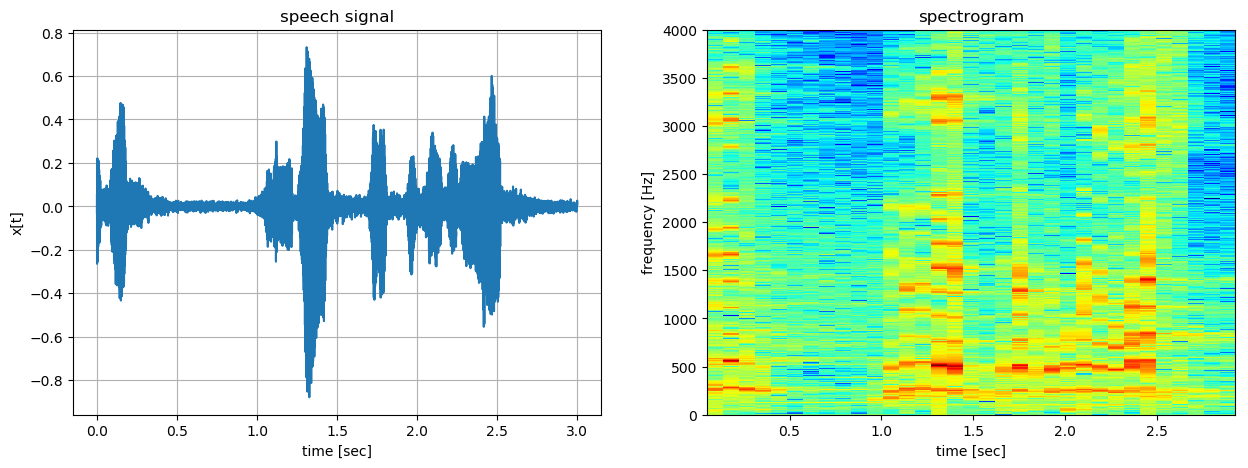

In [4]:
# create figure with subplots
_, ax = plt.subplots(ncols=2, figsize=(15,5))

# plot speech signal as a function of time
ax[1].plot(t, x_time)

# plot spectrogram of speech signal
plot_spectrogram(spectrogram(x_time, convert(Int, 100e-3*fs_desired), convert(Int, 10e-3*fs_desired), fs=fs_desired), fs_desired, ax=ax[2])

# visual modifications
ax[1].grid(), ax[1].set_ylabel("x[t]"), ax[1].set_xlabel("time [sec]"), ax[1].set_title("speech signal"), ax[2].set_title("spectrogram")
;

## Warp signal and calculate warped frequency distribution

In [5]:
# initialize memory vector of taps, Y, with zeros
Y = zeros(nr_taps_warped*3,1)

# initialize memory struct for filter taps and spectrum coefficients
mem_taps = Array{Array{Float64,1}}(undef, length(x_time))
mem_spec = Array{Complex{Float64},2}(undef, length(x_time), nr_taps_warped)

# get update matrices as defined in thesis
W, U = allpass_update_matrix(nr_taps_warped, z_pole)

# loopt through time-domain signal
for k = 1:length(x_time)
    
    # update memory vector of taps and taps themselves
    Y, mem_taps[k] = allpass_update(x_time[k], Y, nr_taps_warped, z_pole, T=W, u=U)

    # calculate windowed FFT of taps
    mem_spec[k,:] = FFTW.fft(window(nr_taps_warped).*mem_taps[k])
    
end

# discard frequency components concerning non-positive frequencies (are complex conjugate, because of real temporal signal)
if nr_taps_warped%2 == 0
    mem_spec = hcat(mem_spec[:, 2:Int(nr_taps_warped/2)], conj.(mem_spec[:, Int(nr_taps_warped/2)+1]))
else
    mem_spec = mem_spec[:, 2:Int(ceil(nr_taps_warped/2))]
end

# calculate real and imaginary parts of remaining frequency components
mem_spec_real = real(mem_spec)
mem_spec_imag = imag(mem_spec)
;

## Warped spectral distribution visualization

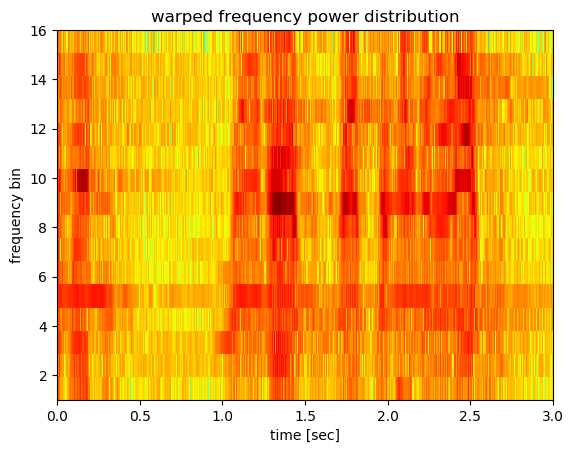

In [6]:
# calculate power of spectral components
mem_spec_pwr = 20*log10.(abs.(mem_spec))'

# plot warped power spectrum
plt.imshow(mem_spec_pwr, aspect="auto", cmap="jet", origin="lower", extent=[t[1], t[end], 1, Int(floor(nr_taps_warped/2))]), plt.xlabel("time [sec]"), plt.ylabel("frequency bin"), plt.title("warped frequency power distribution")
;

## Single bin visualization

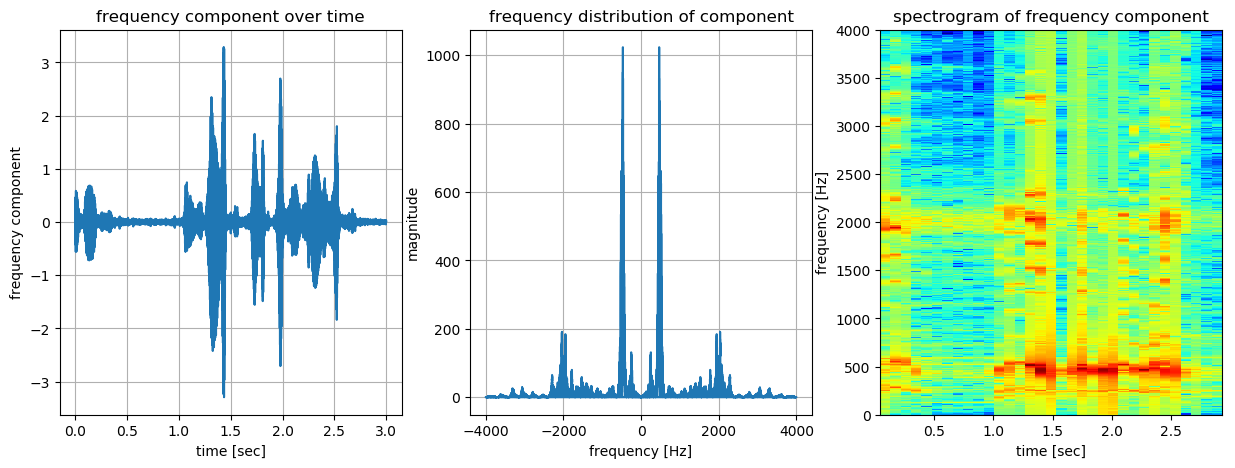

In [7]:
# select specified frequency bin
if bin_c == "real"
    spec_select = mem_spec_real[:, bin]
else
    spec_select = mem_spec_imag[:, bin]
end

# create subplots
_, ax = plt.subplots(ncols=3, figsize=(15,5))

# plot frequency component as a function of time
ax[1].plot(t, spec_select)

# plot frequency distribution of frequency component
ax[2].plot(FFTW.fftfreq(length(spec_select), fs_desired), abs.(FFTW.fft(spec_select)))

# plot spectrogram of speech signal
plot_spectrogram(spectrogram(spec_select, convert(Int, 100e-3*fs_desired), convert(Int, 10e-3*fs_desired), fs=fs_desired), fs_desired, ax=ax[3])

# change visuals
ax[1].grid(), ax[1].set_xlabel("time [sec]"), ax[1].set_ylabel("frequency component"), ax[1].set_title("frequency component over time"), ax[2].grid(), ax[2].set_xlabel("frequency [Hz]"), ax[2].set_ylabel("magnitude"), ax[2].set_title("frequency distribution of component"), ax[3].set_title("spectrogram of frequency component")
;

## Generative model and inference

In [8]:
# create factor graphs
fg = FactorGraph()

# AR node
@RV γ ~ ForneyLab.Gamma(placeholder(:a_γ), placeholder(:b_γ))
@RV θ ~ GaussianMeanPrecision(placeholder(:μ_θ, dims=(AR_order,)), placeholder(:Λ_θ, dims=(AR_order, AR_order)))
@RV Sprev ~ GaussianMeanPrecision(placeholder(:μ_Sprev, dims=(AR_order,)), placeholder(:Λ_Sprev, dims=(AR_order, AR_order)))
@RV S ~ LAR.AR.Autoregressive(θ, Sprev, γ)

# selection and input
d = zeros(AR_order)
d[1] = 1
@RV x ~ DotProduct(d, S)
@RV v ~ GaussianMeanPrecision(0, Λ_meas)
@RV y = x + v
placeholder(y, :y)

ForneyLab.draw(fg)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.38.0 (20140413.2041)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 8540971616029064226 -->
 8540971616029064226 
 
 placeholder_μ_Sprev 
 
<!-- 13559215658093141658 -->
 13559215658093141658 
 
 placeholder_b_γ 
 
<!-- 10101445550772966931 -->
 10101445550772966931 
 
 𝒩 
 gaussianmeanprecision_3 
 
<!-- 1152518200519723275 -->
 1152518200519723275 
 
 clamp_2 
 
<!-- 10101445550772966931--1152518200519723275 -->
 10101445550772966931--1152518200519723275 
 
 clamp_2 
 1 out 
 2 m 
 
<!-- 14769443418016343246 -->
 14769443418016343246 
 
 clamp_3 
 
<!-- 10101445550772966931--14769443418016343246 -->
 10101445550772966931--14769443418016343246 
 
 clamp_3 
 1 out 
 3 w 
 
<!-- 17475271471490788252 -->
 17475271471490788252 
 
 clamp_1 
 
<!-- 9309231734590480210 -->
 9309231734590480210 
 
 placeholder_a_γ 
 
<!-- 16819952707741554065 -->
 16819952707741554065 
 
 𝒩 
 gaussianmeanprecision_1 
 
<!-- 356490392952558936 -->
 356490392952558936 
 
 placeholder_μ_θ 
 
<!-- 16819952707741554065--356490392952558936 -->
 16819952707741554065--356490392952558936 
 
 μ_θ 
 1 out 
 2 m 
 
<!-- 3630771280809571690 -->
 3630771280809571690 
 
 placeholder_Λ_θ 
 
<!-- 16819952707741554065--3630771280809571690 -->
 16819952707741554065--3630771280809571690 
 
 Λ_θ 
 1 out 
 3 w 
 
<!-- 905259250390057974 -->
 905259250390057974 
 
 AR 
 autoregressive_1 
 
<!-- 905259250390057974--16819952707741554065 -->
 905259250390057974--16819952707741554065 
 
 θ 
 1 out 
 3 θ 
 
<!-- 669277482012231344 -->
 669277482012231344 
 
 𝒩 
 gaussianmeanprecision_2 
 
<!-- 905259250390057974--669277482012231344 -->
 905259250390057974--669277482012231344 
 
 Sprev 
 1 out 
 2 x 
 
<!-- 12401043510306662175 -->
 12401043510306662175 
 
 Gam 
 gamma_1 
 
<!-- 905259250390057974--12401043510306662175 -->
 905259250390057974--12401043510306662175 
 
 γ 
 1 out 
 4 γ 
 
<!-- 12287343421568199295 -->
 12287343421568199295 
 
 placeholder_y 
 
<!-- 16647819265961624389 -->
 16647819265961624389 
 
 + 
 addition_1 
 
<!-- 12287343421568199295--16647819265961624389 -->
 12287343421568199295--16647819265961624389 
 
 y 
 1 out 
 1 out 
 
<!-- 16647819265961624389--10101445550772966931 -->
 16647819265961624389--10101445550772966931 
 
 v 
 1 out 
 3 in2 
 
<!-- 4794379669411066910 -->
 4794379669411066910 
 
 dot 
 dotproduct_1 
 
<!-- 16647819265961624389--4794379669411066910 -->
 16647819265961624389--4794379669411066910 
 
 x 
 1 out 
 2 in1 
 
<!-- 4794379669411066910--17475271471490788252 -->
 4794379669411066910--17475271471490788252 
 
 clamp_1 
 1 out 
 2 in1 
 
<!-- 4794379669411066910--905259250390057974 -->
 4794379669411066910--905259250390057974 
 
 S 
 1 y 
 3 in2 
 
<!-- 669277482012231344--8540971616029064226 -->
 669277482012231344--8540971616029064226 
 
 μ_Sprev 
 1 out 
 2 m 
 
<!-- 17135428670859944268 -->
 17135428670859944268 
 
 placeholder_Λ_Sprev 
 
<!-- 669277482012231344--17135428670859944268 -->
 669277482012231344--17135428670859944268 
 
 Λ_Sprev 
 1 out 
 3 w 
 
<!-- 12401043510306662175--13559215658093141658 -->
 12401043510306662175--13559215658093141658 
 
 b_γ 
 1 out 
 3 b 
 
<!-- 12401043510306662175--9309231734590480210 -->
 12401043510306662175--9309231734590480210 
 
 a_γ 
 1 out 
 2 a

In [9]:
# specify recognition factorization and create algorithm
q = RecognitionFactorization(θ, S, Sprev, γ, ids=[:Θ :S :Sprev :γ])
algo = compatibility_fix(variationalAlgorithm(q))

# evaluate algorith 
eval(Meta.parse(algo))
;

In [10]:
# priors
current_a_γ = 0.001
current_b_γ = 0.001
current_Λ_θ = 1e0*Ic(AR_order) #1e4*diagm(randn(AR_order))
current_μ_θ = randn(AR_order)
current_μ_Sprev = randn(AR_order)
current_Λ_Sprev = tiny*diagm(randn(AR_order))
F_tot = []
a_γ_tot = []
b_γ_tot = []
μ_S_tot = []
Λ_S_tot = []
μ_θ_tot = []
Λ_θ_tot = []
μ_pred = Float64[]
μ_pred2 = Float64[]
messages=Array{Message}(undef, 6)

p = Progress(length(spec_select), 1, "Observed ")
marginals = Dict()

# loop through signal samples
for sp in 1:length(spec_select)
    
    # update progress bar
    update!(p, sp)
    
    
    # update marginals
    marginals[:θ] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=current_μ_θ, w=current_Λ_θ)
    marginals[:γ] = ProbabilityDistribution(Univariate, Gamma, a=current_a_γ, b=current_b_γ)
    marginals[:Sprev] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=current_μ_Sprev, w=current_Λ_Sprev)
    
    # perform VMP iterations
    for it = 1:iterations
        
        # update data dictionary
        data = Dict(:y => spec_select[sp],
                    :μ_Sprev => current_μ_Sprev,
                    :Λ_Sprev => current_Λ_Sprev,
                    :μ_θ => current_μ_θ,
                    :Λ_θ => current_Λ_θ,
                    :a_γ => current_a_γ,
                    :b_γ => current_b_γ)
        
        marginals = Base.invokelatest(stepS!, data, marginals, messages)  
        if it == 1
            push!(μ_pred2, ForneyLab.unsafeMean(messages[3].dist))
        end
        
        # perform inference
        data, marginals = step_all!(data, marginals)
        
        # save new parameters
        push!(a_γ_tot, marginals[:γ].params[:a])
        push!(b_γ_tot, marginals[:γ].params[:b])
        push!(μ_S_tot, ForneyLab.unsafeMean(marginals[:S])[1])
        push!(Λ_S_tot, ForneyLab.unsafePrecision(marginals[:S])[1])
        push!(μ_θ_tot, ForneyLab.unsafeMean(marginals[:θ]))
        push!(Λ_θ_tot, ForneyLab.unsafePrecision(marginals[:θ]))
        
        # update current parameters
        current_μ_θ = ForneyLab.unsafeMean(marginals[:θ])
        current_Λ_θ = ForneyLab.unsafePrecision(marginals[:θ])
        current_a_γ = marginals[:γ].params[:a]
        current_b_γ = marginals[:γ].params[:b]
        current_μ_Sprev = ForneyLab.unsafeMean(marginals[:Sprev])
        current_Λ_Sprev = ForneyLab.unsafePrecision(marginals[:Sprev])
    end
    
    current_μ_Sprev = ForneyLab.unsafeMean(marginals[:S])
    current_Λ_Sprev = ForneyLab.unsafePrecision(marginals[:S])
    
    # perform 1 step prediction
    push!(μ_pred, sum(current_μ_Sprev.*current_μ_θ))
    
end
;

Observed 100%|██████████████████████████████████████████| Time: 0:02:19m


## Visualize results of 1 step prediction

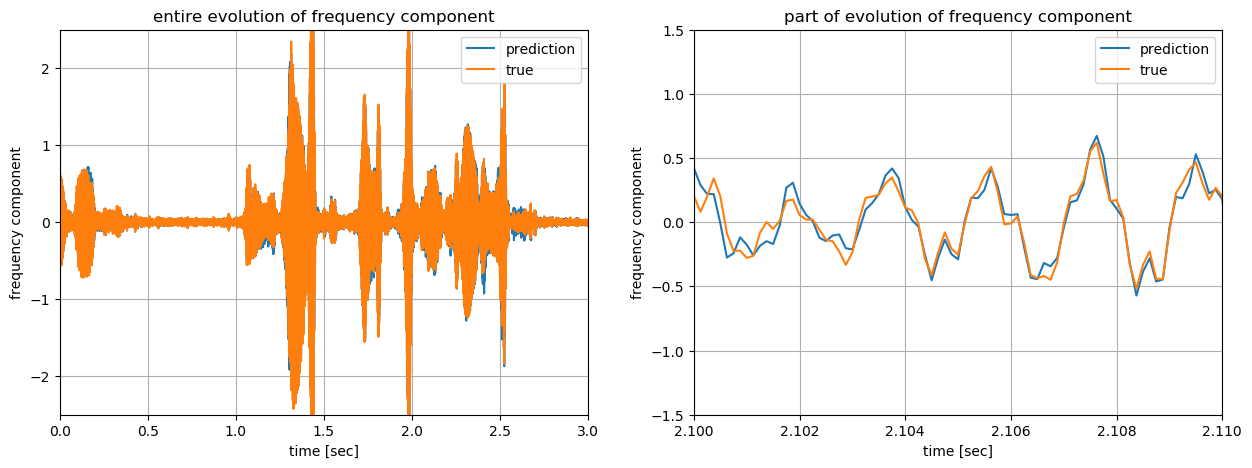

In [11]:
# create figure 
_, ax = plt.subplots(ncols=2, figsize=(15,5))

# plot prediction of frequency component
ax[1].plot(t[2:end], μ_pred[1:end-1], label="prediction"), ax[2].plot(t[2:end], μ_pred[1:end-1], label="prediction")

# plot true evolution of frequency component # add offset because prediction is only performed for second sample forwards
ax[1].plot(t[2:end], spec_select[2:end], label="true"), ax[2].plot(t[2:end], spec_select[2:end], label="true") 

# change visualization
ax[1].legend(), ax[1].grid(), ax[1].set_xlabel("time [sec]"), ax[1].set_ylabel("frequency component"), ax[1].set_title("entire evolution of frequency component"), ax[1].set_xlim(0, 3)
ax[2].legend(), ax[2].grid(), ax[2].set_xlabel("time [sec]"), ax[2].set_ylabel("frequency component"), ax[2].set_title("part of evolution of frequency component")
ax[2].set_xlim(2.1, 2.11), ax[2].set_ylim(-1.5,1.5), ax[1].set_ylim(-2.5, 2.5)
;

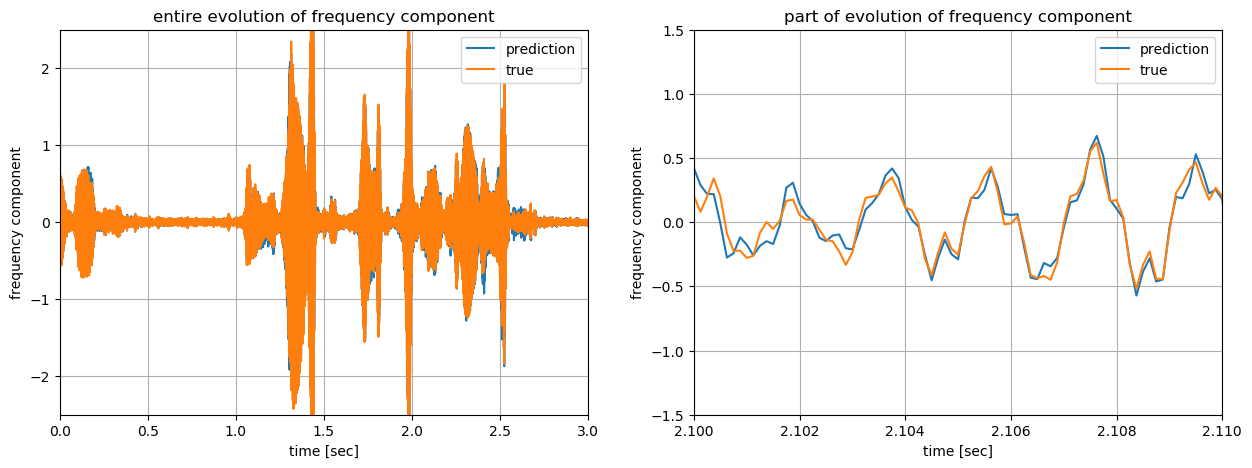

In [12]:
# create figure 
_, ax = plt.subplots(ncols=2, figsize=(15,5))

# plot prediction of frequency component
ax[1].plot(t[1:end], μ_pred2[1:end], label="prediction"), ax[2].plot(t[1:end], μ_pred2[1:end], label="prediction")

# plot true evolution of frequency component # add offset because prediction is only performed for second sample forwards
ax[1].plot(t[1:end], spec_select[1:end], label="true"), ax[2].plot(t[1:end], spec_select[1:end], label="true") 

# change visualization
ax[1].legend(), ax[1].grid(), ax[1].set_xlabel("time [sec]"), ax[1].set_ylabel("frequency component"), ax[1].set_title("entire evolution of frequency component"), ax[1].set_xlim(0, 3)
ax[2].legend(), ax[2].grid(), ax[2].set_xlabel("time [sec]"), ax[2].set_ylabel("frequency component"), ax[2].set_title("part of evolution of frequency component")
ax[2].set_xlim(2.1, 2.11), ax[2].set_ylim(-1.5,1.5), ax[1].set_ylim(-2.5, 2.5)
;

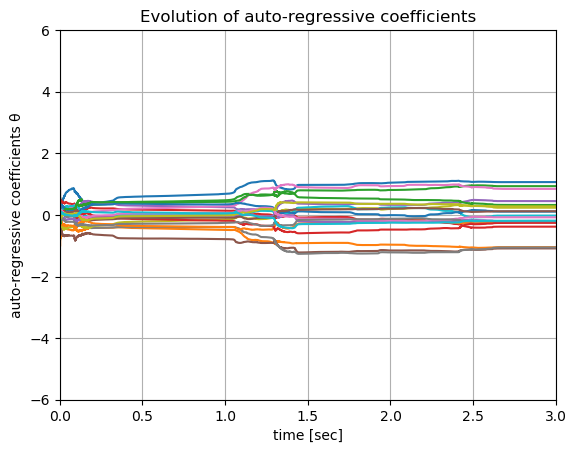

In [13]:
# loop through auto-regressive coefficients
for ki = 1:AR_order
    
    # plot auto-regressive coefficients
    plt.plot(t, [μ_θ_tot[k][ki] for k=1:iterations:length(μ_θ_tot)])
    
end

# change visualization
plt.grid(), plt.ylim(-6, 6), plt.xlim(0, 3), plt.xlabel("time [sec]"), plt.ylabel("auto-regressive coefficients θ"), plt.title("Evolution of auto-regressive coefficients")
;

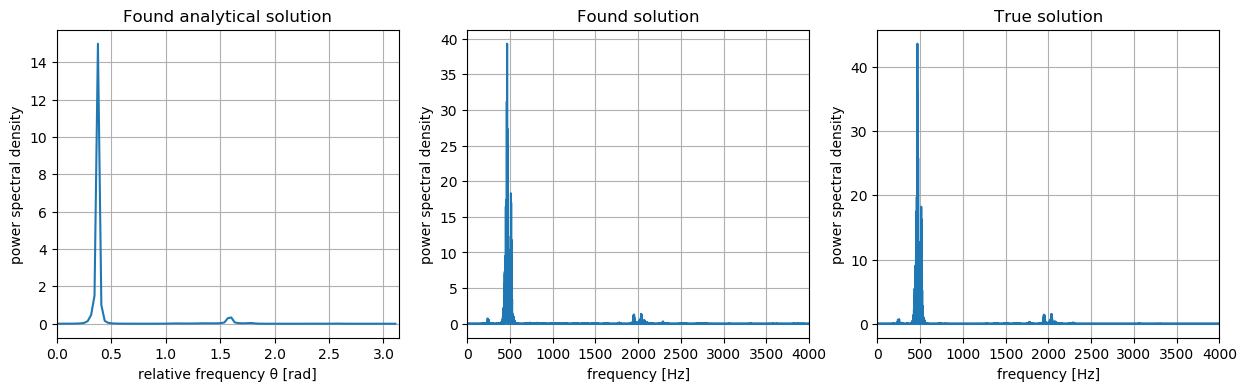

In [14]:
# specify range of normalized frequency
theta = 0:pi/100:pi

# approximate variance of process noise by mode
pn_var = 1/((current_a_γ-1)/current_b_γ) 

# calculate analytical power spectral density of the evolution of the spectral coefficients
psd = pn_var ./(abs.([sum(-append!([-1.], μ_θ_tot[end]).*exp.(-collect(0:AR_order)*1im.*th)) for th in theta]).^2)

# create figure
_, ax = plt.subplots(ncols=3, figsize=(15,4))

# plot analytical solution of PSD
ax[1].plot(theta, psd)

# plot prediction of PSD
ax[2].plot(FFTW.fftfreq(length(μ_pred[1:end-1]), fs_desired), (abs.(FFTW.fft(μ_pred[1:end-1])).^2)./length(μ_pred[1:end-1]))

# plot FFT solution of PSD
ax[3].plot(FFTW.fftfreq(length(spec_select), fs_desired), (abs.(FFTW.fft(spec_select)).^2)./length(spec_select))

# change visualisation
ax[1].grid(), ax[2].grid(), ax[3].grid(), ax[1].set_xlabel("relative frequency θ [rad]"), ax[2].set_xlabel("frequency [Hz]"), ax[3].set_xlabel("frequency [Hz]"), ax[1].set_ylabel("power spectral density"), ax[2].set_ylabel("power spectral density"), ax[3].set_ylabel("power spectral density"), ax[1].set_title("Found analytical solution"), ax[2].set_title("Found solution"), ax[3].set_title("True solution"), ax[1].set_xlim(0, pi), ax[2].set_xlim(0, fs_desired/2), ax[3].set_xlim(0, fs_desired/2)
;

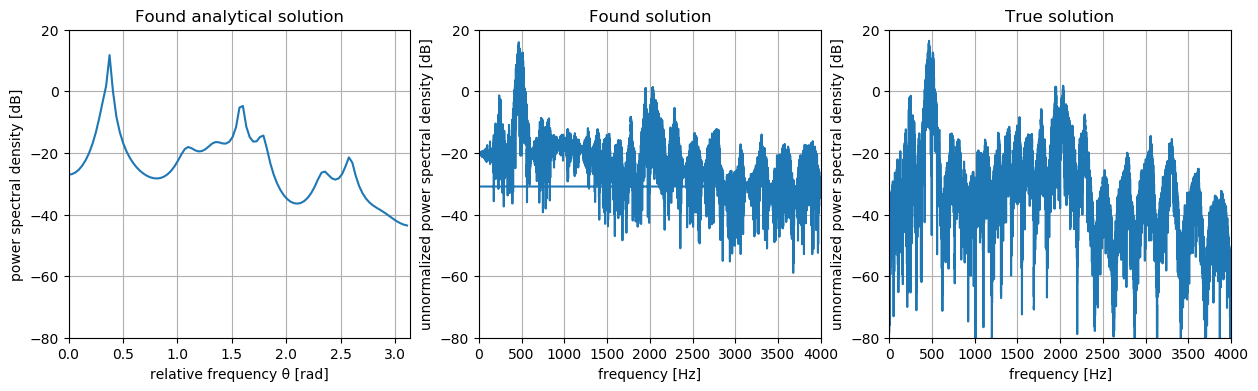

In [15]:
# specify range of normalized frequency
theta = 0:pi/100:pi

# approximate variance of process noise by mode
pn_var = 1/((current_a_γ-1)/current_b_γ) 

# calculate analytical power spectral density of the evolution of the spectral coefficients
psd = pn_var ./(abs.([sum(-append!([-1.], μ_θ_tot[end]).*exp.(-collect(0:AR_order)*1im.*th)) for th in theta]).^2)

# create figure
_, ax = plt.subplots(ncols=3, figsize=(15,4))

# plot analytical solution of PSD
ax[1].plot(theta, 10*log10.(psd))

# plot prediction of PSD
ax[2].plot(FFTW.fftfreq(length(μ_pred[1:end-1]), fs_desired), 10*log10.((abs.(FFTW.fft(μ_pred[1:end-1])).^2)./length(μ_pred[1:end-1])))

# plot FFT solution of PSD
ax[3].plot(FFTW.fftfreq(length(spec_select), fs_desired), 10*log10.((abs.(FFTW.fft(spec_select)).^2)./length(spec_select)))


# change visualisation
ax[1].grid(), ax[2].grid(), ax[3].grid(), ax[1].set_xlabel("relative frequency θ [rad]"), ax[2].set_xlabel("frequency [Hz]"), ax[3].set_xlabel("frequency [Hz]"), ax[1].set_ylabel("power spectral density [dB]"), ax[2].set_ylabel("unnormalized power spectral density [dB]"), ax[3].set_ylabel("unnormalized power spectral density [dB]"), ax[1].set_title("Found analytical solution"), ax[2].set_title("Found solution"), ax[3].set_title("True solution"), ax[1].set_xlim(0, pi), ax[2].set_xlim(0, fs_desired/2), ax[3].set_xlim(0, fs_desired/2)
ax[1].set_ylim(ax[3].get_ylim()[1], ax[3].get_ylim()[2])
ax[1].set_ylim(-80, 20), ax[2].set_ylim(-80,20), ax[3].set_ylim(-80,20)
;

In [16]:
h5open("../inferred_values/speech_AR_"*string(AR_order, pad=2)*".h5", "w") do file
    if bin_c == "real"
        write(file, "bin_real_"*string(bin, pad=2)*"/theta_mean", current_μ_θ)
        write(file, "bin_real_"*string(bin, pad=2)*"/theta_precision", current_Λ_θ) 
        write(file, "bin_real_"*string(bin, pad=2)*"/gamma_a", current_a_γ) 
        write(file, "bin_real_"*string(bin, pad=2)*"/gamma_b", current_a_γ) 
    else
        write(file, "bin_imag_"*string(bin, pad=2)*"/theta_mean", current_μ_θ)
        write(file, "bin_imag_"*string(bin, pad=2)*"/theta_precision", current_Λ_θ) 
        write(file, "bin_imag_"*string(bin, pad=2)*"/gamma_a", current_a_γ) 
        write(file, "bin_imag_"*string(bin, pad=2)*"/gamma_b", current_a_γ) 
    end
end